In earlier tutorials, we have already worked with image classification. In this tutorial, we are going to work with another common form of data -- text. We will be developing and evaluating text classifiers -- specifically fake news classifiers -- using Keras.

# Data and Preparation

## Importing Data
Let's first import the necessary libraries for this project:

In [2]:
import tensorflow as tf
import keras
from keras import layers, losses
from keras.layers import TextVectorization
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

Let's now load the data for this project:

In [3]:
train_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_train.csv"
df = pd.read_csv(train_url)

df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


Inspecting our data, we see that each row of the data corresponds to an article. The title column gives the title of the article, while the text column gives the full article text. The final column, called fake, is 0 if the article is true and 1 if the article contains fake news.

## Dataset Preprocessing
Next, we will write a function called `make_dataset` that prepares the data for training. This function will perform the following steps:

- Convert text to lowercase: This ensures that the model treats words like "News" and "news" as the same.

- Remove stopwords: Stopwords are common words like "the," "and," or "but" that are usually uninformative for text classification tasks. We will remove these to reduce noise in the data.

- Construct a tf.data.Dataset: The dataset will have two inputs (the title and text) and one output (the fake label).

In [4]:
import nltk
from nltk.corpus import stopwords

# Get stopwords
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

def make_dataset(dataframe, batch_size=100):

    # Create a copy of the dataframe
    clean_df = dataframe.copy()

    # Clean title and text columns
    for column in ['title', 'text']:
        clean_df[column] = clean_df[column].apply(lambda text: clean_text(text))

    # Create and return the dataset
    features = {"title": clean_df["title"], "text": clean_df["text"]}
    labels = clean_df["fake"]

    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(len(clean_df), reshuffle_each_iteration=False)
    dataset = dataset.batch(batch_size)

    return dataset

def clean_text(text):

    if not isinstance(text, str):
        return ""

    words = text.lower().split()
    clean_words = [word for word in words if word not in english_stopwords]
    return " ".join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Validation Data
For this project, we will use 20% of out data for the validation set.



In [5]:
total_samples = len(df)
train_ratio = 0.8  # Use 80% for training
train_samples = int(train_ratio * total_samples)
val_samples = total_samples - train_samples

# Create and split dataset
dataset = make_dataset(df)
train_dataset = dataset.take(train_samples // 100)  # Divide by batch size (100)
val_dataset = dataset.skip(train_samples // 100)


### Base Rate
The base rate refers to the accuracy of a model that always predicts the majority class. Calculating the base rate helps us understand the performance of a naive model and provides a benchmark for our classifier.

Let’s calculate the base rate for our dataset:

In [6]:
# Calculate the proportion of fake news articles in the training set
base_rate = df['fake'].mean()
print(f"Base rate: {base_rate:.2f}")

Base rate: 0.52


### Text Vectorization
To process the text data for our model, we'll use TensorFlow's text vectorization layer to vectorize our data:

In [7]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                 '[%s]' % re.escape(string.punctuation), '')
    return no_punctuation

# Create vectorization layers
title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500)

# Adapt the vectorization layers to the data
title_vectorize_layer.adapt(train_dataset.map(lambda x, y: x["title"]))
text_vectorize_layer.adapt(train_dataset.map(lambda x, y: x["text"]))

# Building Keras Models

For this project, we are using Keras models to investigate the following question: when detecting fake news, it is most effective to focus on only the title of the article, the full text of the article, or both?

Before writing any model, let's implement some functions for training the model and visualizing the result:

In [8]:
def train_model(model, train_data, val_data, max_epochs=20):
   # Configure early stopping to prevent overfitting
   early_stopping = keras.callbacks.EarlyStopping(
       monitor='val_loss',
       patience=3,
       restore_best_weights=True
   )

   # Train the model
   history = model.fit(
       train_data,
       validation_data=val_data,
       epochs=max_epochs,
       callbacks=[early_stopping],
       verbose=1
   )

   # Evaluate and print final performance
   _, accuracy = model.evaluate(val_data)
   print(f"validation accuracy: {accuracy:.4f}")

   return history


def visualize_accuracy(history, title="Model Accuracy"):
   plt.figure(figsize=(10, 6))

   # Plot accuracy metrics
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

   # Configure the plot
   plt.title(title)
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(loc='lower right')
   plt.grid(True, linestyle='--', alpha=0.7)

   plt.tight_layout()
   plt.show()

## First Model

For the first model, we will only use the article title as an input.

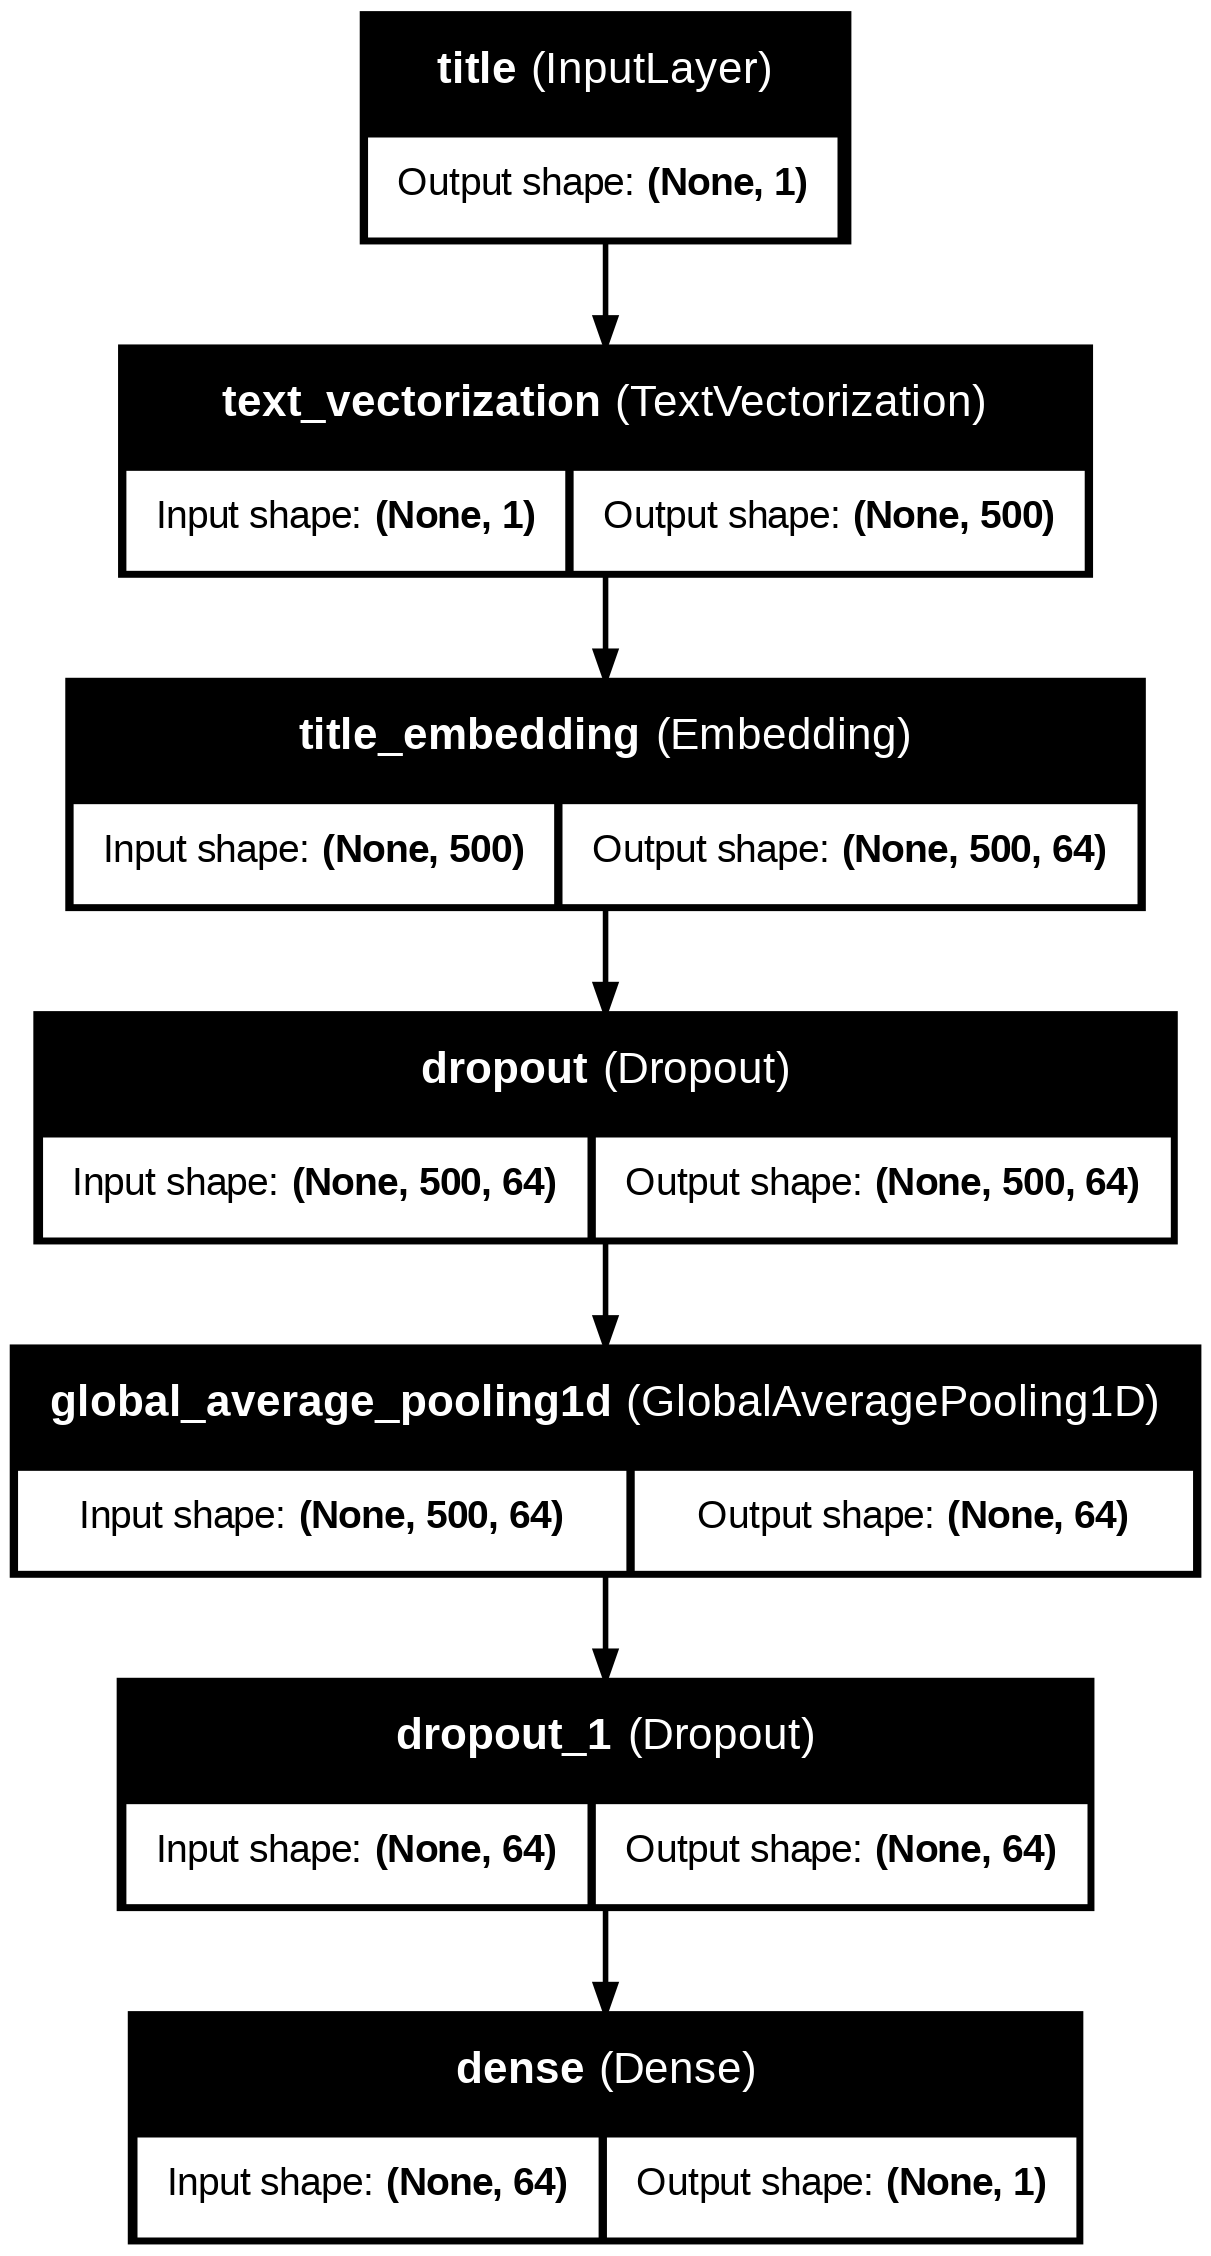

In [9]:
title_input = keras.Input(shape=(1,), name="title", dtype="string")
x = title_vectorize_layer(title_input)
x = layers.Embedding(size_vocabulary, output_dim=64, name="title_embedding")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

title_model = keras.Model(inputs={"title": title_input}, outputs=output)
title_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

from keras.utils import plot_model
plot_model(title_model, "title.png", show_shapes=True, show_layer_names=True)

Let's see the performance of our model and visualize the model accuracy:

In [10]:
title_history = train_model(title_model, train_dataset, val_dataset)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'title': 'title'}
Received: inputs={'title': 'Tensor(shape=(None,))', 'text': 'Tensor(shape=(None,))'}
  warnings.warn(msg)


179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6073 - loss: 0.6722 - val_accuracy: 0.8934 - val_loss: 0.5729
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8238 - loss: 0.5356 - val_accuracy: 0.9272 - val_loss: 0.4049
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8846 - loss: 0.3875 - val_accuracy: 0.9316 - val_loss: 0.3078
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9086 - loss: 0.3013 - val_accuracy: 0.9457 - val_loss: 0.2545
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9226 - loss: 0.2548 - val_accuracy: 0.9468 - val_loss: 0.2233
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9279 - loss: 0.2264 - val_accuracy: 0.9530 - val_loss: 0.2026
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9357 - loss: 0.2042 - val_accuracy: 0.9565 - val_loss: 0.1884
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9407 - loss: 0.1903 - val_accuracy: 0.958

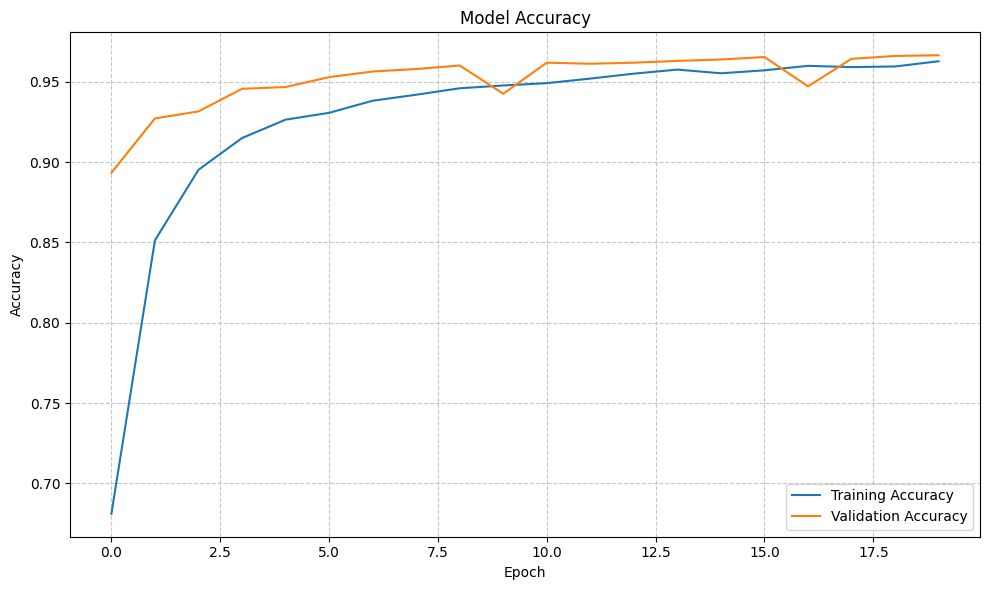

In [11]:
visualize_accuracy(title_history)

From the graph, we observe that the model accuracy stablizes at around 97%.

## Second Model

For the second model, we will only use the article text as an input.

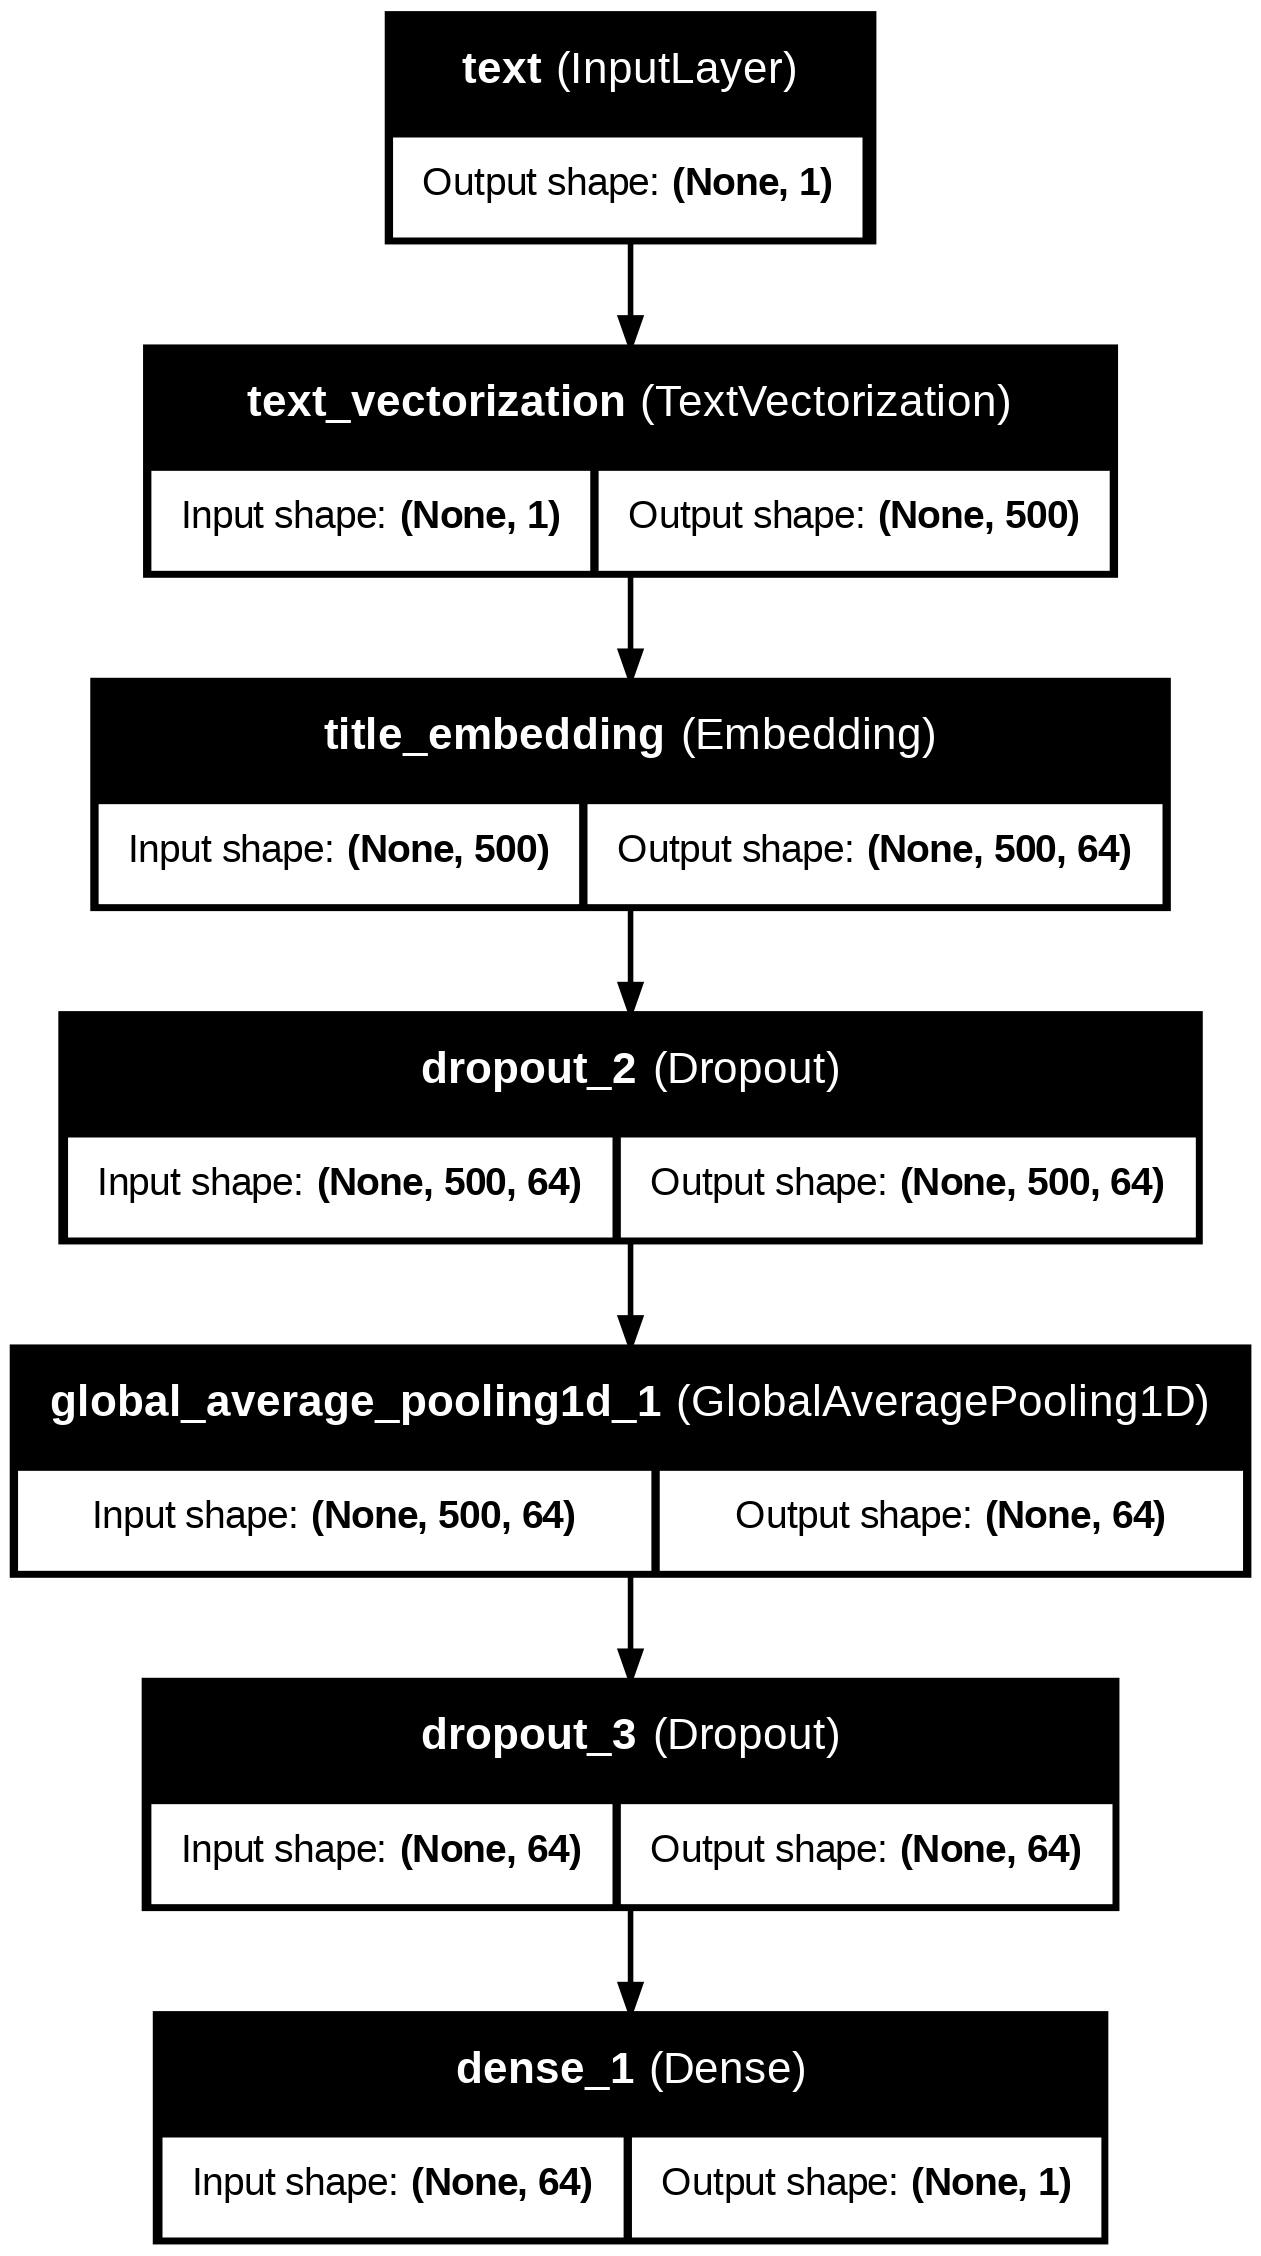

In [12]:
text_input = keras.Input(shape=(1,), name="text", dtype="string")
x = title_vectorize_layer(text_input)
x = layers.Embedding(size_vocabulary, output_dim=64, name="title_embedding")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

text_model = keras.Model(inputs={"text": text_input}, outputs=output)
text_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

plot_model(text_model, "text.png", show_shapes=True, show_layer_names=True)

Let's train this model and visualize its result:

In [13]:
text_history = train_model(text_model, train_dataset, val_dataset)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'text': 'text'}
Received: inputs={'title': 'Tensor(shape=(None,))', 'text': 'Tensor(shape=(None,))'}
  warnings.warn(msg)


179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6099 - loss: 0.6729 - val_accuracy: 0.9107 - val_loss: 0.5759
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8201 - loss: 0.5378 - val_accuracy: 0.9151 - val_loss: 0.4069
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8891 - loss: 0.3875 - val_accuracy: 0.9316 - val_loss: 0.3080
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9074 - loss: 0.3022 - val_accuracy: 0.9442 - val_loss: 0.2548
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9216 - loss: 0.2554 - val_accuracy: 0.9521 - val_loss: 0.2249
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9323 - loss: 0.2245 - val_accuracy: 0.9530 - val_loss: 0.2028
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9333 - loss: 0.2069 - val_accuracy: 0.9569 - val_loss: 0.1881
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9410 - loss: 0.1912 - val_accuracy: 0.958

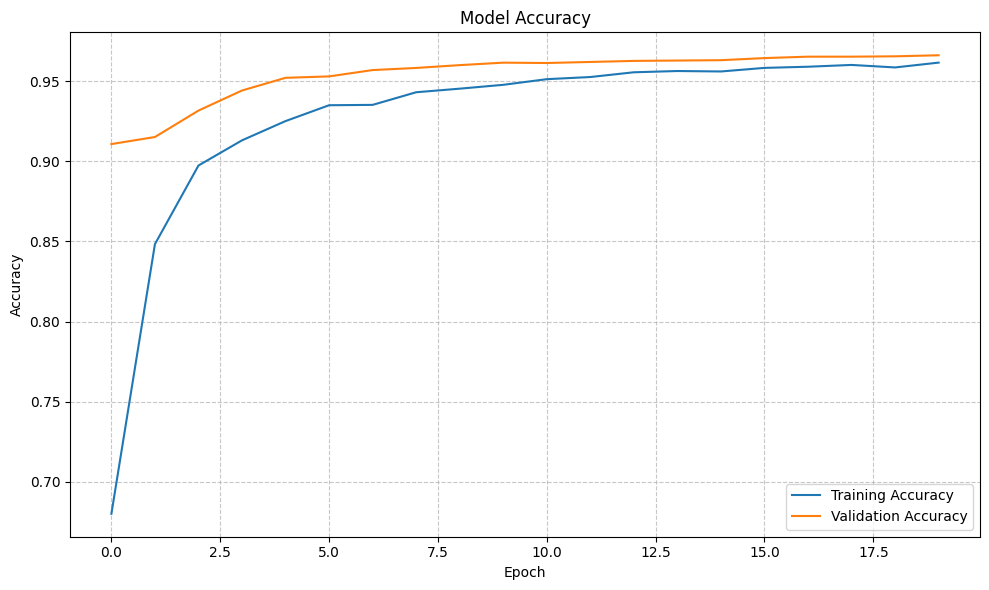

In [14]:
visualize_accuracy(text_history)

We observe from the graph this time the validation accuracy is more stable than the first model, achieving around 97% accuracy.

## Third Model

For the third model, we are going to investigate the combined effect when we have both the article title and the article text as inputs.

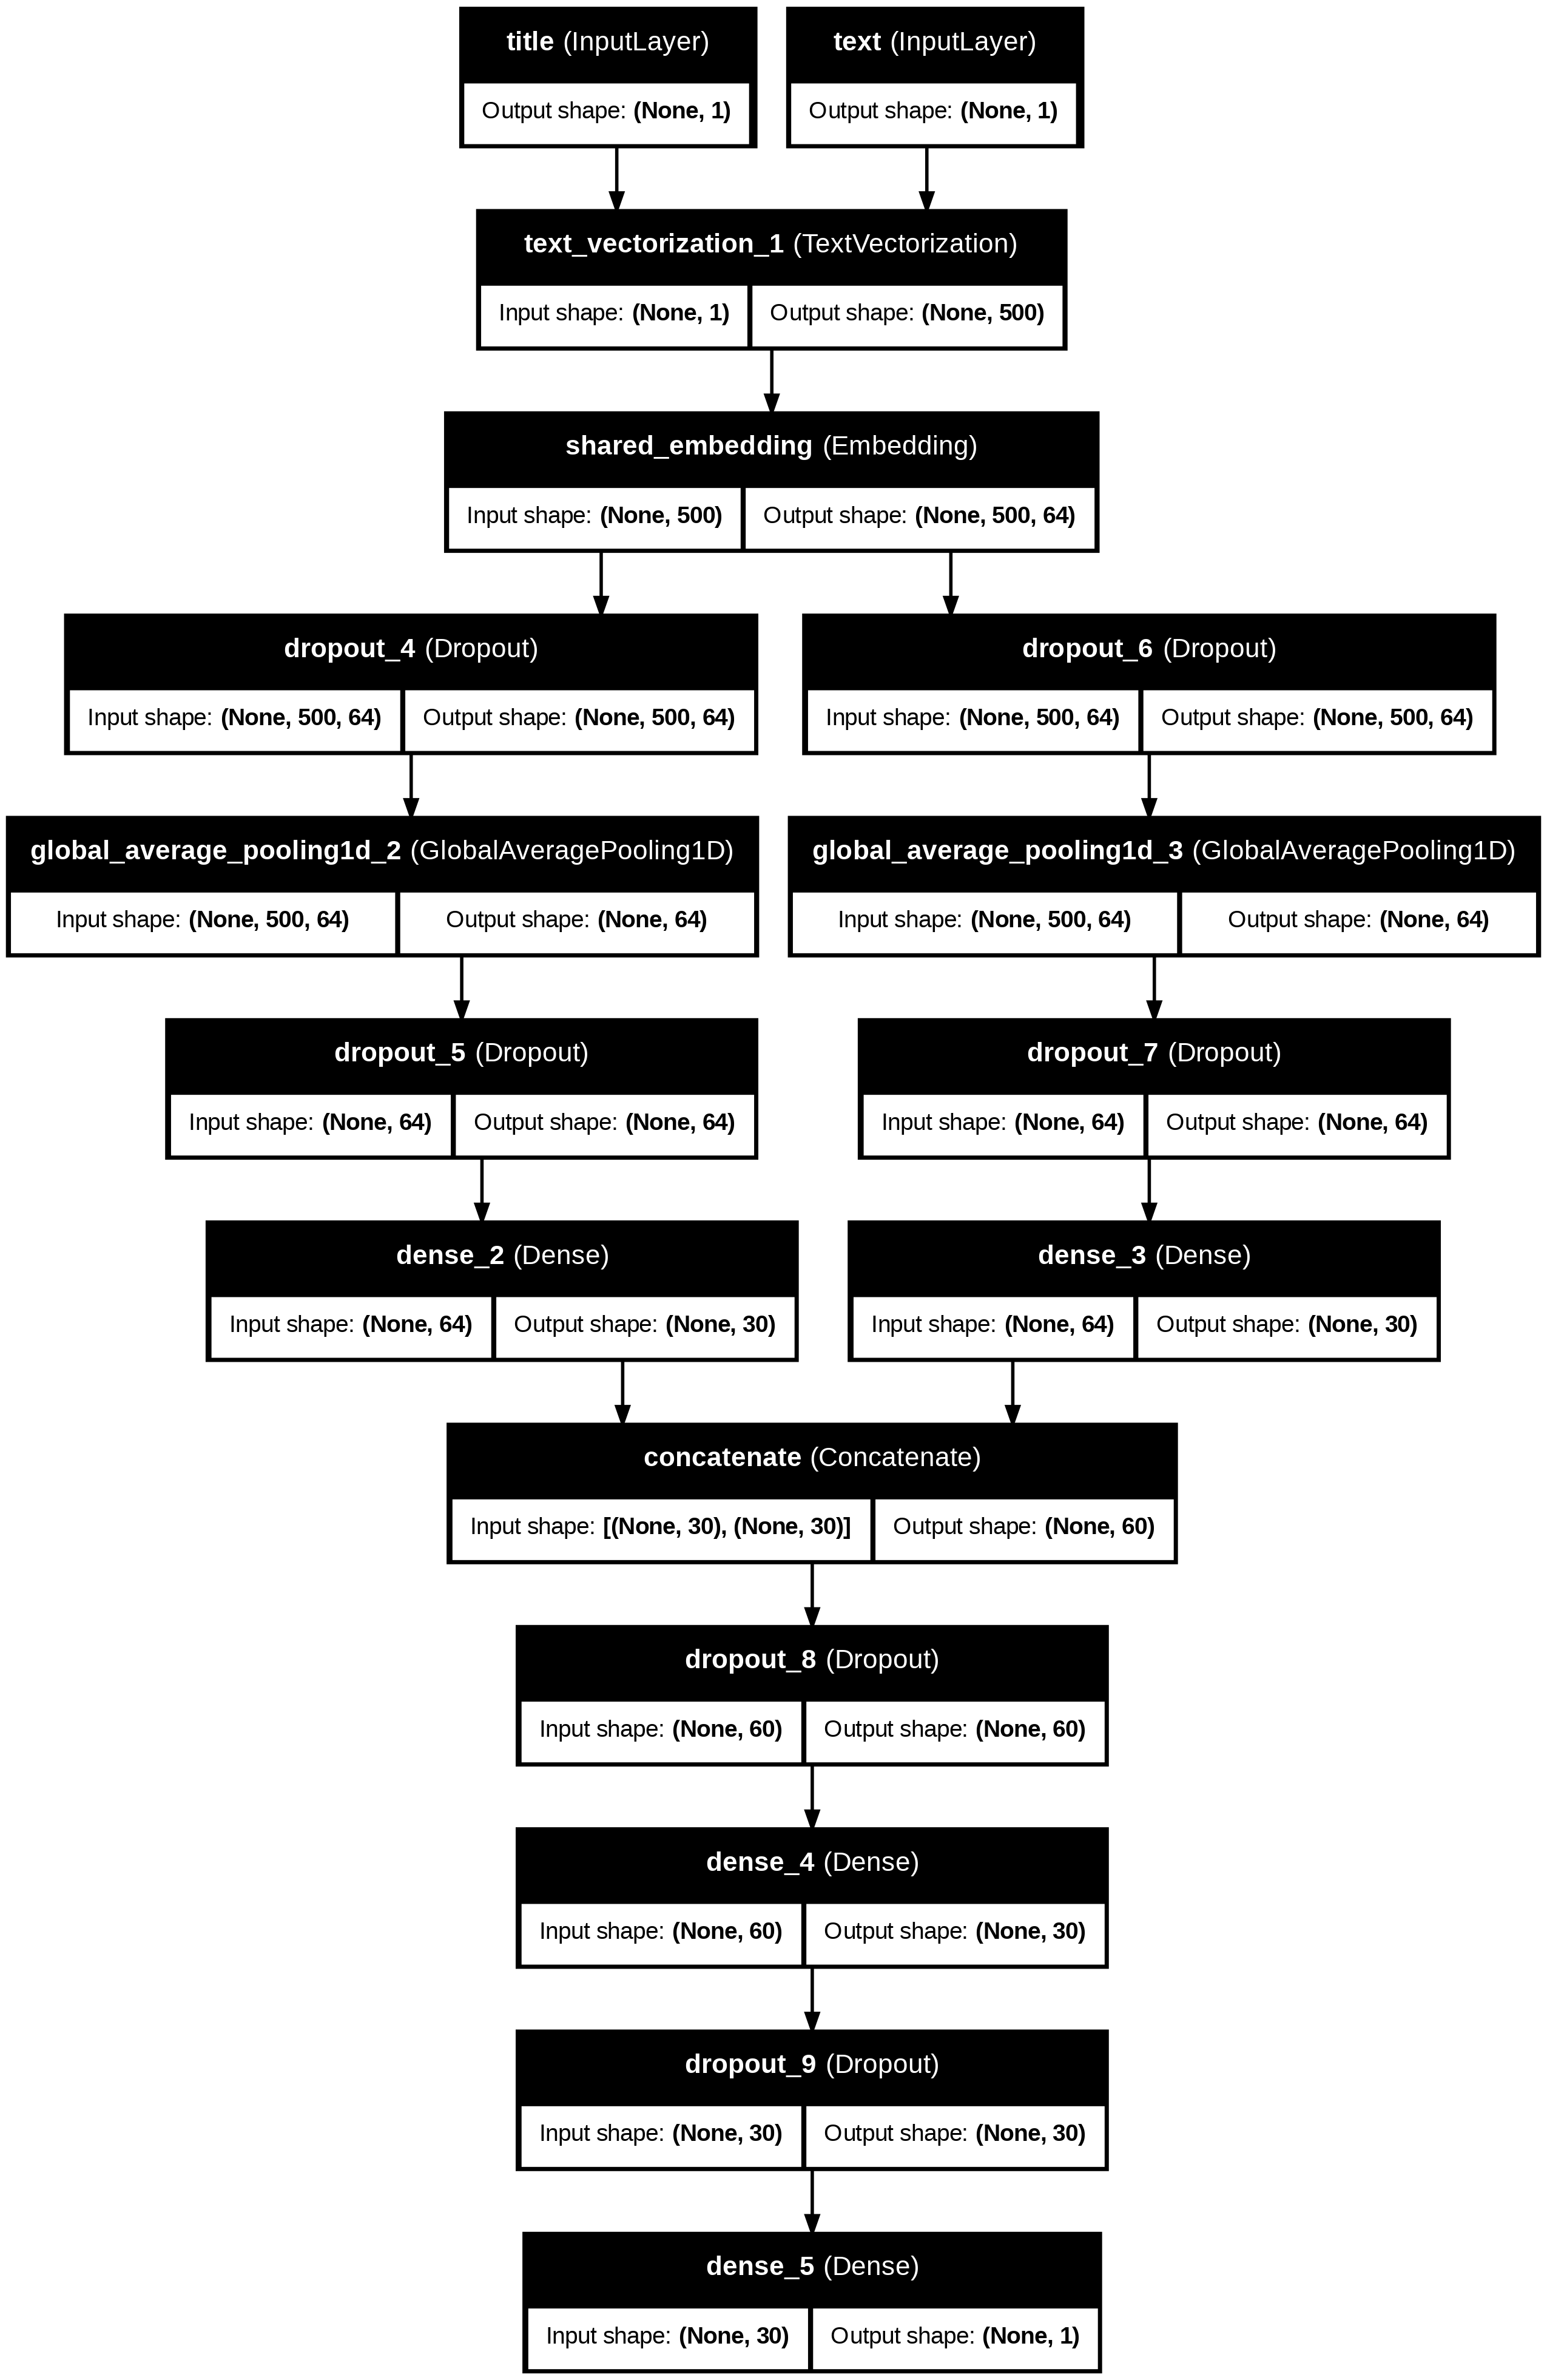

In [15]:
t = text_vectorize_layer(title_input)
x = text_vectorize_layer(text_input)

# Shared embedding layer
shared_embedding = layers.Embedding(
    size_vocabulary,
    output_dim=64,
    name="shared_embedding"
)

# Title branch
t = shared_embedding(t)
t = layers.Dropout(0.5)(t)
t = layers.GlobalAveragePooling1D()(t)
t = layers.Dropout(0.5)(t)
t = layers.Dense(30, activation="relu")(t)

# Text branch
x = shared_embedding(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(30, activation="relu")(x)

# Combine branches
mixed = layers.concatenate([t, x])
x = layers.Dropout(0.5)(mixed)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Create and compile model
mixed_model = keras.Model(inputs={"title": title_input, "text": text_input}, outputs=output)
mixed_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
plot_model(mixed_model, "mixed.png", show_shapes=True, show_layer_names=True)

Let's also train the model and visualize its result:

In [27]:
mixed_history = train_model(mixed_model, train_dataset, val_dataset)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9723 - loss: 0.0782 - val_accuracy: 0.9776 - val_loss: 0.0838
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9770 - loss: 0.0670 - val_accuracy: 0.9813 - val_loss: 0.0769
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9598 - loss: 0.0974 - val_accuracy: 0.9822 - val_loss: 0.0777
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9777 - loss: 0.0631 - val_accuracy: 0.9765 - val_loss: 0.0835
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9739 - loss: 0.0703 - val_accuracy: 0.9780 - val_loss: 0.0768
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9714 - loss: 0.0747 - val_accuracy: 0.9802 - val_loss: 0.0774
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9794 - loss: 0.0563 - val_accuracy: 0.9820 - val_loss: 0.0758
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9761 - loss: 0.0666 - val_accu

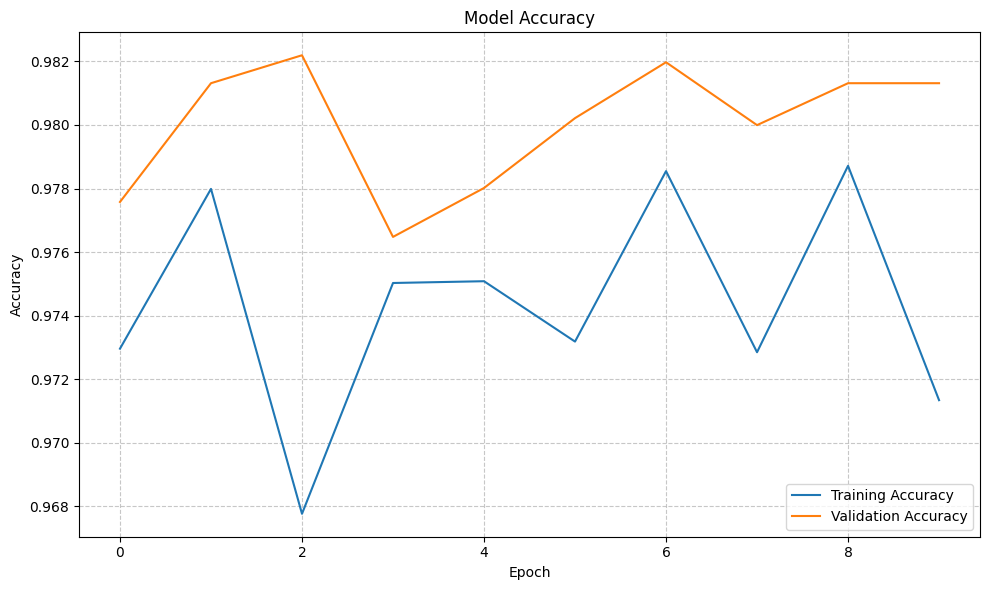

In [28]:
visualize_accuracy(mixed_history)

From the graph, we observe that the model accuracy is also very high, stably maintaining a level of around 98%. As a result, model 3 performs the best out of the three models.

# Evaluation

From the previous section, we see that the third model that combines both title and text as input performs the best among the three models. Let's now evaluate its performance on the test dataset.

In [29]:
test_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_test.csv"
test_df = pd.read_csv(test_url)

test = make_dataset(test_df)

test_loss, test_accuracy = mixed_model.evaluate(test)
print(f"Test accuracy: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9757 - loss: 0.0925
Test accuracy: 0.9779


Great! We have achieved a test accuracy of 97.79% on our test dataset. Therefore, we can make the conclusion that model 3 that combines both the article title and the article text is the most accurate.